In [1]:
%matplotlib inline

In [215]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
sns.set('paper', 'ticks', None)

In [4]:
textwidth = 460.72124 / 72.27
row_height = textwidth / 1.5 / 1.6
single_fig_size = [textwidth / 1.5, row_height]

# Differentiator

In [181]:
class Differentiator(object):
    def __init__(self, tau1, tau2):
        assert tau1 < tau2
        self.tau1 = tau1
        self.tau2 = tau2
        
    def h1(self, t):
        assert np.all(t >= 0.)
        return np.exp(-t / self.tau1) / self.tau1
    
    def h2(self, t):
        assert np.all(t >= 0.)
        return np.exp(-t / self.tau2) / self.tau2
    
    def __call__(self, x, t):
        t_long = np.arange(0., 100. * max(self.tau1, self.tau2), t[1] - t[0])
        a = self.h1(t)
        a /= np.sum(a) * (t_long[1] - t_long[0])
        b = self.h2(t)
        b /= np.sum(b) * (t_long[1] - t_long[0])
        return np.convolve(x(t), a - b, 'full')[:len(t)]
    
    def mag_response(self, ω):
        return ω * (self.tau2 - self.tau1) / np.sqrt(
            1. + (self.tau1 * self.tau2 * ω**2)**2 + ω**2 * (self.tau1**2 + self.tau2**2))

In [166]:
class UnitStep(object):
    def __init__(self, step_t):
        self.step_t = step_t
        
    def __call__(self, t):
        return np.asfarray(t >= self.step_t)

In [182]:
t = np.linspace(0., .6, 300)
u = UnitStep(0.1)
diff = Differentiator(0.005, 0.05)
y = diff(u, t)

In [185]:
f = np.logspace(-2, 3)
ω = 2. * np.pi * f

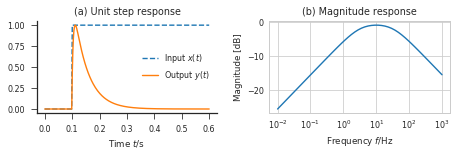

In [213]:
fig = plt.figure(figsize=(textwidth, 0.85 * row_height))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(t, u(t), '--', label="Input $x(t)$")
ax1.plot(t, y / np.max(y), label="Output $y(t)$")
ax1.set_title("(a) Unit step response")
ax1.set_xlabel("Time $t$/s")
ax1.legend(loc='best')
sns.despine(ax=ax1)

with sns.axes_style('whitegrid'):
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(f, 10 * np.log10(diff.mag_response(ω)))
    ax2.semilogx()
    ax2.set_title("(b) Magnitude response")
    ax2.set_xlabel("Frequency $f$/Hz")
    ax2.set_ylabel("Magnitude [dB]")

fig.tight_layout()

In [214]:
fig.savefig('../../../phd-thesis/figures/differentiator.pdf', bbox_inches='tight', pad_inches=0.)

# Integrator

In [234]:
def u(t):
    if t < 1.:
        return 0.
    elif t < 3.:
        return 0.2
    elif t < 4.:
        return 0.
    elif t < 5.:
        return 0.4
    else:
        return 0.

In [235]:
tau = 0.1
with nengo.Network(seed=1) as model:
    ens = nengo.Ensemble(100, 1)
    u_node = nengo.Node(u)
    nengo.Connection(u_node, ens[0], transform=tau)
    nengo.Connection(ens, ens, synapse=tau)
    p_u = nengo.Probe(u_node)
    p_ens = nengo.Probe(ens[0], synapse=0.01)

In [236]:
with nengo.Simulator(model) as sim:
    sim.run(10.)

Building finished in 0:00:01.                                                                                           
Simulating finished in 0:00:02.                                                                                         


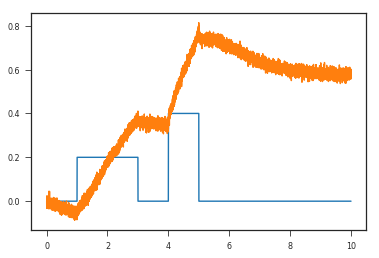

In [237]:
plt.plot(sim.trange(), sim.data[p_u])
plt.plot(sim.trange(), sim.data[p_ens])

In [238]:
sim.data[ens]

BuiltEnsemble(eval_points=array([[ -9.12286554e-01],
       [  7.22567637e-01],
       [ -4.43823239e-01],
       [ -5.25849631e-01],
       [  5.27897779e-01],
       [ -2.01341860e-01],
       [ -4.93818105e-01],
       [ -9.45183303e-01],
       [ -6.33416136e-01],
       [  3.40670494e-01],
       [ -5.36557105e-01],
       [ -5.98722781e-02],
       [  1.00643097e-01],
       [ -6.10702824e-01],
       [  3.00526332e-01],
       [ -5.84826070e-01],
       [ -4.33030307e-02],
       [ -8.20878929e-01],
       [  5.91917504e-02],
       [  5.91216849e-01],
       [ -8.69078465e-01],
       [ -4.86524035e-02],
       [  9.04415085e-02],
       [  4.70413742e-01],
       [  9.17465361e-01],
       [  4.55003167e-01],
       [  4.37166812e-01],
       [ -3.44916088e-01],
       [  1.25281568e-01],
       [  2.89101085e-01],
       [  4.90057881e-01],
       [ -3.44708799e-01],
       [  6.17072165e-01],
       [ -7.24640118e-01],
       [ -6.07592185e-01],
       [  2.28876222e-01],
  